In [ ]:
# pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import math

# Getting Data and Preprocessing

In [ ]:
#Getting GLD Data
target = 'GLD'
def getTargetData(target):
  ticker = yf.Ticker(target)
  start = "2000-01-01"
  end = "2022-01-01"
  data = ticker.history(start="2000-01-01", end = "2023-01-01", interval="1d")
  df = pd.DataFrame(data)
  df.drop(labels = ['High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Capital Gains'], axis = 1, inplace = True)
  df.rename(columns = {'Open' : target}, inplace = True)
  return df
# df.head()


In [ ]:
def addTicker(df, name):
  ticker = yf.Ticker(name)
  data = ticker.history(start="2000-01-01", end = "2022-01-01", interval="1d")
  df2 = pd.DataFrame(data)
  df2.rename(columns = {'Open' : name}, inplace = True)
  # print(df2)
  # print(df2.index.values)
  df[name] = df2[name]
  if df[name].isnull().values[0]:
    df.drop(name, axis=1, inplace=True)
  return
  # df.head()

In [ ]:
def movingAvgMomentum(df1, days, tickers):
  df2 = df1.copy()
  df2 = df2[days + 1:]
  for ticker in tickers:
    vals = []
    # print(len(df1))
    sum = 0
    for i in range(1, len(df1)):
      sum = sum + df1.iloc[i-1][ticker]
      if i > days:
        sum = sum - df1.iloc[i - days - 1][ticker]
        avg = sum/days
        percentChange = (df1.iloc[i][ticker] - avg)/avg
        vals.append(percentChange)
    # print(len(df1))
    # print(len(vals))
    df2[('Momentum' + ticker)] = vals
  return df2

In [ ]:
def makeTarget(df, target, days):
  vals = []
  for i in range(len(df) - days):
    if df.iloc[i+days][target] >= df.iloc[i][target]:
      vals.append(1)
    else:
      vals.append(0)
  df.drop(df.tail(days).index, inplace = True)
  df['Target'] = vals
  return df


In [ ]:
def percentChange(df1, tickers = []):
  #using z score
  df2 = df1.copy()
  vals = []
  for feature in tickers:
    for i in range(1, len(df1)):      
      df2[feature][i] = (df1[feature][i] - df1[feature][i-1])/df1[feature][i-1]
  df2 = df2[1:]
  return df2


In [ ]:
#Getting price data
target = 'GLD'
df = getTargetData(target)
features = {'SPY', 'HG=F', '^TNX', '^VIX'}
for ticker in features:
  addTicker(df, ticker)

#Getting federal funds rate data
from datetime import datetime
import pytz

fed_rates = pd.read_csv('FedRates.csv')
fed_rates.head()
dates = []
for i in range(len(fed_rates)):
  dateStr = fed_rates.iloc[i]['Date']
  date = datetime.strptime(dateStr, '%m/%d/%y')
  monthStr = str(date.month)
  if date.month < 10:
    monthStr = '0' + str(date.month)
  dayStr = str(date.day)
  if date.day < 10:
    dayStr = '0' + str(date.day)

  str1 = str(date.year) + '-' + monthStr + '-' + dayStr + 'T05:00'
  # date = np.datetime64(str1)
  dates.append(str1)
fed_rates['dates'] = dates

#Adding fed rate data to dataframe
j = 0
vals = []
for i in range(len(df)):
  index = df.index.values[i]
  date = np.datetime64(fed_rates.iloc[j]['dates'])
  while date - index < np.timedelta64(2,'h'):
    j = j + 1
    date = np.datetime64(fed_rates.iloc[j]['dates'])
  vals.append(fed_rates.iloc[j]['Rate'])
  
df['FedRate'] = vals

#Adding binary data for target - whether the price of GLD goes up in 5 days or not
df = makeTarget(df, target, 5)
df.dropna(axis = 0, inplace = True)

#Adding percent change between moving average and current price to show momentum
df = movingAvgMomentum(df, 20, ['GLD', 'SPY', 'HG=F'])

df.dropna(axis=0, inplace = True)
df_prices = df.copy()
df_prices.drop(index=df.index[0], axis=0, inplace=True)
df = percentChange(df, ['GLD', 'SPY', '^VIX', 'HG=F', '^TNX', 'FedRate'])
df.head()

<ipython-input-343-753744fda309>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[feature][i] = (df1[feature][i] - df1[feature][i-1])/df1[feature][i-1]


,GLD,^VIX,^TNX,HG=F,SPY,FedRate,Target,MomentumGLD,MomentumSPY,MomentumHG=F
Date,,,,,,,,,,
2004-12-22 00:00:00-05:00,0.001586,-0.030560,0.001675,0.008347,0.006522,0.040000,0,-0.007143,0.015281,0.047211
2004-12-23 00:00:00-05:00,-0.000679,-0.000876,0.006213,-0.026490,0.004070,-0.029915,0,-0.007204,0.017800,0.017671
2004-12-27 00:00:00-05:00,0.002717,0.010517,0.006649,-0.031973,0.002730,-0.013216,0,-0.003712,0.019079,-0.015037
2004-12-28 00:00:00-05:00,0.002935,0.062446,0.014862,0.062544,-0.004621,-0.004464,0,-0.000068,0.012886,0.049071
2004-12-29 00:00:00-05:00,-0.011256,-0.052245,-0.002092,-0.013889,0.003648,0.004484,0,-0.010566,0.015554,0.031495


# Training and Testing Base Model

In [ ]:
split1 = math.floor(0.8 * len(df_prices))
split2 = math.floor(0.55 * split1)
df_prices_test = df_prices.iloc[split2:split1, :].copy()
df_prices_metatest = df_prices.iloc[split1:, :].copy()

#Splitting training and testing
totalDays = len(df)
split = math.floor(0.8 * totalDays)
df_train = df.iloc[:split, :].copy()
df_test = df.iloc[split:, :].copy()

split = math.floor(0.55 * len(df_train))
base_train = df_train.iloc[:split, :].copy()
base_test = df_train.iloc[split:, :].copy()


In [ ]:
#Splitting into x and y for base model
x_train = base_train.drop(columns = ['Target'])
y_train = base_train['Target']
x_test = base_test.drop(columns = ['Target'])
y_test = base_test['Target']

In [ ]:
def getInfo(df, actual, predicted):
  tp = 0
  fp = 0
  p = 0
  n = 0
  correctness = []
  for i in range(len(df)):
    if df.iloc[i][predicted] == 1:
      if df.iloc[i][actual] == 1:
        tp = tp + 1
        p = p + 1
        correctness.append(1)
      else:
        fp = fp + 1
        n = n + 1
        correctness.append(0)
    else:
      if df.iloc[i][actual] == 1:
        # tp = tp + 1
        p = p + 1
        correctness.append(0)
      else:
        # fp = fp + 1
        n = n + 1
        correctness.append(1)

  # df_prices_test.drop(df_prices_test.tail(holding).index, inplace = True)
  # df_prices_test['Labels'] = correctness

  tpr = tp/p
  fpr = fp/n

  print('tpr', tpr)
  print('fpr', fpr)
  print('actual predicted num')
  print('1 1', tp)
  print('1 0', (p - tp))
  print('0 1', fp)
  print('0 0', (n - fp))
  return tpr, fpr

In [ ]:
import matplotlib.pyplot as plt 
def rocCurve(results):
  threshold = 0
  threshold_axis = []
  false_positive_ratio_axis = []
  true_positive_ratio_axis = []
  for i in range(400, 600, 1):
      threshold = i / 1000.0 
      actual_negatives = 0
      false_positives = 0

      actual_positives = 0
      true_positives = 0
      for j in range(len(results)):
        # print(results['Actual'][j])
        #if (results.iloc[j]['Probabilities'])[1] > threshold and results['Actual'][j] == 1:
          #true_positives = true_positives + 1
        if (results.iloc[j]['Probabilities'])[1] > threshold and results['Actual'][j] == 0:
          false_positives = false_positives + 1
        if results['Actual'][j] == 0:
          actual_negatives = actual_negatives + 1

        if (results.iloc[j]['Probabilities'])[1] > threshold and results['Actual'][j] == 1:
          true_positives = true_positives + 1
        if results['Actual'][j] == 1:
          actual_positives = actual_positives + 1
        #false positives over total number of zeros
      false_positive_ratio =  -1 if actual_negatives == 0 else (false_positives / actual_negatives)
      true_positive_ratio =  -1 if actual_positives == 0 else (true_positives / actual_positives)
      #print(ratio)
      threshold_axis.append(threshold)
      false_positive_ratio_axis.append(false_positive_ratio)
      true_positive_ratio_axis.append(true_positive_ratio)

  roc = pd.DataFrame()
  roc['Threshold'] = threshold_axis
  roc['FPR'] = false_positive_ratio_axis
  roc['TPR'] = true_positive_ratio_axis
  
  plt.plot(threshold_axis, false_positive_ratio_axis)
  plt.xlabel("Threshold")
  plt.ylabel("Ratio of False Positives to Actual Negatives")
  plt.show()

  plt.plot(threshold_axis, true_positive_ratio_axis)
  plt.xlabel("Threshold")
  plt.ylabel("Ratio of True Positives to Actual Positives")
  plt.show()

  plt.plot(false_positive_ratio_axis, true_positive_ratio_axis)
  plt.xlabel("Ratio of False Positives to Actual Negatives")
  plt.ylabel("Ratio of True Positives to Actual Positives")
  plt.show()

  return roc




In [ ]:
#Running prediction model for base model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


#Trying different models:
# base_model = LinearRegression()
base_model = LogisticRegression()
#classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
#classifier = SVC(kernel = 'linear', random_state = 0)
# base_model = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
# classifier = SVC(kernel = 'sigmoid', random_state = 0)

base_model.fit(x_train, y_train)

y_pred = base_model.predict_proba(x_test)

results = pd.DataFrame()
results['Actual'] = y_test
results['Probabilities'] = y_pred.tolist()


In [ ]:
plotRoc = False
if plotRoc:
  roc = rocCurve(results)

In [ ]:
results.iloc[20:30]

,Actual,Probabilities
Date,,
2012-07-24 00:00:00-04:00,1,"[0.43695391727709576, 0.5630460827229042]"
2012-07-25 00:00:00-04:00,0,"[0.43138932426993803, 0.568610675730062]"
2012-07-26 00:00:00-04:00,0,"[0.4370998330891609, 0.5629001669108391]"
2012-07-27 00:00:00-04:00,0,"[0.43584360195238336, 0.5641563980476166]"
2012-07-30 00:00:00-04:00,0,"[0.43541152595238275, 0.5645884740476173]"
2012-07-31 00:00:00-04:00,0,"[0.4292043114502547, 0.5707956885497453]"
2012-08-01 00:00:00-04:00,1,"[0.4367544527142925, 0.5632455472857075]"
2012-08-02 00:00:00-04:00,1,"[0.4361303416586053, 0.5638696583413947]"
2012-08-03 00:00:00-04:00,1,"[0.4389574073622484, 0.5610425926377516]"


In [ ]:
#Prediction to long or not based on threshold
threshold = 0.562
binarySignals = []
for i in range(len(results)):
  if (results.iloc[i]['Probabilities'])[1] > threshold:
    binarySignals.append(1)
  else:
    binarySignals.append(0)
results['BinarySignals'] = binarySignals
results.head()

base_test_results = df_prices_test.copy()
base_test_results['BaseSignal'] = results['BinarySignals']
base_test_results['SignalProbs'] = [x[1] for x in results['Probabilities']]

getInfo(results, 'Actual', 'BinarySignals')

tpr 0.9184782608695652
fpr 0.8692403486924035
actual predicted num
1 1 676
1 0 60
0 1 698
0 0 105


(0.9184782608695652, 0.8692403486924035)

In [ ]:
# #Feature importance
# from matplotlib import pyplot
# importance = base_model.coef_[0]
# # summarize feature importance
# for i,v in enumerate(importance):
#  print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()

# Backtesting Base Strategy

In [ ]:
def backtest(df_prices_test, holding, metalabeled = False, signalCol = 'Signal'):
  i = 0
  start = 100
  cash = start
  sharesHolding = 0
  # holding = 10
  portfolio = []
  spyHold = []
  bbhHold = []
  dailyRet = []
  dailyRet.append(0)
  endHold = 0
  spyShares = cash/df_prices_test.iloc[0]['SPY']
  bbhShares = cash/df_prices_test.iloc[0][target]
  count = 0
  neg_returns = []

  peak = start
  max_drawdown = 0
  for i in range(len(df_prices_test)):
    portfolioToday = cash + sharesHolding * df_prices_test.iloc[i][target]
    portfolio.append(portfolioToday)
    peak = max(peak, portfolioToday)
    max_drawdown = min(max_drawdown, portfolioToday/peak-1)
    if i > 0:
      ret = (portfolio[len(portfolio) - 1] - portfolio[len(portfolio) - 2])/portfolio[len(portfolio) - 2]
      dailyRet.append(ret)
      if ret < 0:
        neg_returns.append(ret)
    spyHold.append(spyShares * df_prices_test.iloc[i]['SPY'])
    bbhHold.append(bbhShares * df_prices_test.iloc[i][target])
    if i < endHold:
      continue
    if i == endHold:
      cash = cash + sharesHolding * df_prices_test.iloc[i][target]
      sharesHolding = 0
    if df_prices_test.iloc[i][signalCol] == 1:
      if metalabeled and df_prices_test.iloc[i]['Signal2'] != 1:
        continue
      count = count + 1
      sharesHolding = sharesHolding + cash/df_prices_test.iloc[i][target]
      # print("day", i)
      cash = 0
      endHold = i + holding

  df_prices_test['Portfolio'] = portfolio
  df_prices_test['SPYHold'] = spyHold
  df_prices_test['HoldTarget'] = bbhHold
  df_prices_test['Daily Returns'] = dailyRet

  totalRet = (df_prices_test.iloc[len(df_prices_test) - 1]['Portfolio'] - start)/start
  print("total ret",totalRet)
  
  dates = list(df_prices_test.index.values)
  rounded = np.array(dates, dtype='datetime64[D]')
  time = rounded[len(rounded) - 1] - rounded[0]
  days = time/np.timedelta64(1, 'D')
  years = days/365.0
  # ratio_num = (np.mean(df_prices_test['Daily Returns']) + 1)**252-1 - (1.035**years - 1)
  rfr = 0.035
  ratio_num = (np.mean(df_prices_test['Daily Returns'])+1)**252-1 - rfr
  # rfr = (1.035**years - 1)
  # ratio_num = totalRet - rfr
  print('avg daily returns', np.mean(df_prices_test['Daily Returns']))
  print('ratio num', ratio_num)
  print("rfr", rfr)
  # sharpe = ratio_num/(np.std(df_prices_test['Daily Returns'])*(252**0.5))
  sharpe = ratio_num/(np.std(df_prices_test['Daily Returns'])*(len(df_prices_test)**0.5))
  sortino = ratio_num/(np.std(neg_returns)*(len(df_prices_test)**0.5))

  return sharpe, max_drawdown, sortino
  # sortino = ratio_num/(np.std(neg_pcts)*(252**0.5))
  # sharpe = (totalRet - 0.035)/np.std(df_prices_test['Daily Returns'])


In [ ]:
def getStats(df_prices_test, holding):
  tp = 0
  fp = 0
  p = 0
  n = 0
  correctness = []
  for i in range(len(df_prices_test) - holding):
    price = df_prices_test.iloc[i][target]
    forwardPrice = df_prices_test.iloc[i + holding][target]
    if df_prices_test.iloc[i]['Signal'] == 1:
      if price <= forwardPrice:
        tp = tp + 1
        p = p + 1
        correctness.append(1)
      else:
        fp = fp + 1
        n = n + 1
        correctness.append(0)
    else:
      if price <= forwardPrice:
        p = p + 1
        correctness.append(0)
      else:
        n = n + 1
        correctness.append(1)

  df_prices_test.drop(df_prices_test.tail(holding).index, inplace = True)
  df_prices_test['Labels'] = correctness

  tpr = tp/p
  fpr = fp/n

  print('tpr', tpr)
  print('fpr', fpr)
  return tpr, fpr

In [ ]:
#Backtesting base strategy
sharpe, max_draw, sortino = backtest(base_test_results, 5, signalCol = 'BaseSignal')
print('sharpe: ', sharpe, 'max drawdown ', max_draw, 'sortino', sortino)
base_test_results.plot(y=['Portfolio', 'HoldTarget'])

labels = []
for i in range(len(base_test_results)):
  if base_test_results.iloc[i]['BaseSignal'] == 1 and base_test_results.iloc[i]['Target'] == 1:
    labels.append(1)
  else:
    labels.append(0)

base_test_results['Labels'] = labels
base_test_results

# Meta-labeling (in progress)

In [ ]:
def getMetalabelModel(df):
  # df2 = df.drop(columns = removeCols, inplace = False)
  x_train = df.drop(columns = ['Labels'])
  y_train = df['Labels']
  # classifier = LogisticRegression(random_state = 0)
  classifier = RandomForestClassifier(n_estimators =100, criterion = 'entropy')
  classifier.fit(x_train, y_train)
  return classifier



In [ ]:
def runBaseModel(x_test, y_test):
  y_pred = base_model.predict(x_test)
  y_pred = base_model.predict_proba(x_test)
  results = pd.DataFrame()
  # results['Ticker'] = testRussell2021['Ticker']
  results['Actual'] = y_test
  results['Probabilities'] = y_pred.tolist()

  predicted = []
  for i in range(len(results)):
    if (results.iloc[i]['Probabilities'])[1] > threshold:
      predicted.append(1)
    else:
      predicted.append(0)
  results['Predicted'] = predicted
  return results

In [ ]:
def trainMetaModel(base_model_results, train_features, useProbs = False, stacking = False):
  #First, train metalabel model
  train_features.head()
  train_features.dropna(axis=0, inplace = True)
  meta_train = train_features.iloc[1:, :]
  if useProbs:
    meta_train['Signal'] = base_model_results['SignalProbs']
  else:
    meta_train['Signal'] = base_model_results['BaseSignal']
  if stacking:
    meta_train['Labels'] = meta_train['Target']
  else:
    meta_train['Labels'] = base_model_results['Labels']
  meta_train.dropna(axis=0, inplace = True)
  meta_train.drop(columns = ['Target'], inplace = True)
  metaModel = getMetalabelModel(meta_train)
  return metaModel

In [ ]:
def backtestMeta(df_prices_test, holding, metalabeled = True):
  meta_threshold = 0.45
  i = 0
  start = 100
  cash = start
  sharesHolding = 0
  # holding = 10
  portfolio = []
  spyHold = []
  bbhHold = []
  dailyRet = []
  dailyRet.append(0)
  endHold = 0
  spyShares = cash/df_prices_test.iloc[0]['SPY']
  bbhShares = cash/df_prices_test.iloc[0][target]
  count = 0
  neg_returns = []

  peak = start
  max_drawdown = 0
  for i in range(len(df_prices_test)):
    portfolioToday = cash + sharesHolding * df_prices_test.iloc[i][target]
    portfolio.append(portfolioToday)
    peak = max(peak, portfolioToday)
    max_drawdown = min(max_drawdown, portfolioToday/peak-1)
    if i > 0:
      ret = (portfolio[len(portfolio) - 1] - portfolio[len(portfolio) - 2])/portfolio[len(portfolio) - 2]
      dailyRet.append(ret)
      if ret < 0:
        neg_returns.append(ret)
      
    spyHold.append(spyShares * df_prices_test.iloc[i]['SPY'])
    bbhHold.append(bbhShares * df_prices_test.iloc[i][target])
    if i < endHold:
      continue
    if i == endHold:
      cash = cash + sharesHolding * df_prices_test.iloc[i][target]
      sharesHolding = 0
    if df_prices_test.iloc[i]['BaseSignal'] == 1:
      if metalabeled and (df_prices_test.iloc[i]['Metalabeled'])[1] < meta_threshold:
        continue
      count = count + 1
      tradingCash = ((df_prices_test.iloc[i]['Metalabeled'])[1]/0.50) * cash
      if tradingCash > cash:
        tradingCash = cash
      # tradingCash = cash
      sharesHolding = sharesHolding + tradingCash/df_prices_test.iloc[i][target]
      # print("day", i)
      cash = cash - tradingCash
      endHold = i + holding

  df_prices_test['Portfolio'] = portfolio
  df_prices_test['SPYHold'] = spyHold
  df_prices_test['HoldTarget'] = bbhHold
  df_prices_test['Daily Returns'] = dailyRet
  print('count', count)
  totalRet = (df_prices_test.iloc[len(df_prices_test) - 1]['Portfolio'] - start)/start
  print("total ret",totalRet)
  
  dates = list(df_prices_test.index.values)
  rounded = np.array(dates, dtype='datetime64[D]')
  time = rounded[len(rounded) - 1] - rounded[0]
  days = time/np.timedelta64(1, 'D')
  years = days/365.0
  rfr = 0.035
  ratio_num = (np.mean(df_prices_test['Daily Returns'])+1)**252-1 - rfr
  
  print('avg daily returns', np.mean(df_prices_test['Daily Returns']))
  print('ratio num', ratio_num)
  print("rfr", rfr)
  sharpe = ratio_num/(np.std(df_prices_test['Daily Returns'])*(252**0.5))
  sortino = ratio_num/(np.std(neg_returns)*(252**0.5))
  # sharpe = ratio_num/(np.std(df_prices_test['Daily Returns'])*(len(df_prices_test)**0.5))

  return sharpe, max_drawdown, sortino
  # sortino = ratio_num/(np.std(neg_pcts)*(252**0.5))
  # sharpe = (totalRet - 0.035)/np.std(df_prices_test['Daily Returns'])


In [ ]:
base_test

,GLD,^VIX,^TNX,HG=F,SPY,FedRate,Target,MomentumGLD,MomentumSPY,MomentumHG=F
Date,,,,,,,,,,
2012-06-25 00:00:00-04:00,0.003552,0.097587,-0.010956,0.002576,-8.112344e-03,-0.058824,1,-0.017834,0.000922,-0.018204
2012-06-26 00:00:00-04:00,0.002949,-0.022472,-0.007385,-0.000302,-2.650600e-03,-0.062500,1,-0.015156,-0.001827,-0.016362
2012-06-27 00:00:00-04:00,0.001764,-0.022989,0.012399,0.008317,5.466880e-03,0.000000,1,-0.013279,0.003924,-0.005696
2012-06-28 00:00:00-04:00,-0.009132,0.039898,-0.023270,0.002250,-9.816276e-04,-0.400000,1,-0.023409,0.002732,-0.001733
2012-06-29 00:00:00-04:00,0.021264,-0.138219,0.030094,-0.001347,2.199724e-02,0.000000,0,-0.002601,0.024301,-0.002548
...,...,...,...,...,...,...,...,...,...,...
2018-08-03 00:00:00-04:00,-0.000695,-0.084009,-0.001676,-0.010989,1.123872e-02,0.000000,0,-0.015003,0.010082,-0.027772
2018-08-06 00:00:00-04:00,-0.004605,-0.041834,-0.006378,0.014815,3.928791e-03,0.000000,0,-0.017908,0.012351,-0.011268
2018-08-07 00:00:00-04:00,0.002531,-0.066331,-0.002027,0.000365,6.169656e-03,0.000000,0,-0.013270,0.017310,-0.008949


In [ ]:
useProbs = False
stacking = True
metaModel = trainMetaModel(base_test_results, base_test, useProbs = useProbs, stacking = stacking)

<ipython-input-615-957aabc22f49>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_train['Signal'] = base_model_results['BaseSignal']
<ipython-input-615-957aabc22f49>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_train['Labels'] = meta_train['Target']
/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [ ]:
#Generate signals of base model
x_test = df_test.drop(columns = ['Target'])
y_test = df_test['Target']
finalBaseResults = runBaseModel(x_test, y_test)

results = df_prices_metatest.copy()
results['BaseSignal'] = finalBaseResults['Predicted']
results['BaseProbabilities'] = [x[1] for x in finalBaseResults['Probabilities']]
getInfo(results, 'Target', 'BaseSignal')

tpr 0.8694779116465864
fpr 0.8571428571428571
actual predicted num
1 1 433
1 0 65
0 1 306
0 0 51


(0.8694779116465864, 0.8571428571428571)

In [ ]:
#Run Metalabeling Model
meta_test_features = df_test.copy()
if useProbs:
  meta_test_features['Signal'] = results['BaseProbabilities']
else:
  meta_test_features['Signal'] = results['BaseSignal']

x_test = meta_test_features.drop(columns = ['Target'])
y_test = meta_test_features['Target']

x_test.head()

,GLD,^VIX,^TNX,HG=F,SPY,FedRate,MomentumGLD,MomentumSPY,MomentumHG=F,Signal
Date,,,,,,,,,,
2018-08-10 00:00:00-04:00,-0.001826,0.127971,-0.021334,-0.018406,-0.007284,0.000000,-0.009050,0.006364,-0.005558,1
2018-08-13 00:00:00-04:00,-0.008710,0.175041,-0.008997,-0.012197,0.000070,0.000000,-0.016488,0.005671,-0.017180,1
2018-08-14 00:00:00-04:00,-0.004920,-0.039310,0.010126,-0.011795,-0.001940,0.000000,-0.019761,0.003038,-0.027707,1
2018-08-15 00:00:00-04:00,-0.009536,-0.029433,-0.007950,-0.004103,-0.001909,0.005236,-0.027648,0.000335,-0.030307,1
2018-08-16 00:00:00-04:00,-0.006330,0.048817,0.001045,-0.033146,0.003612,0.000000,-0.032184,0.003625,-0.061136,0


In [ ]:
y_pred = metaModel.predict_proba(x_test)

# resilt = df_prices_metatest.copy()
results['Metalabeled'] = y_pred.tolist()

total ret 0.609917097394355
avg daily returns 0.0005963256849847927
ratio num 0.12710066359365838
rfr 0.035
Sharpe:  0.49006660987452155 max_drawdown -0.18049803360821393 sortino 0.6898307940400525
tpr 0.8694779116465864
fpr 0.8571428571428571
actual predicted num
1 1 433
1 0 65
0 1 306
0 0 51


<AxesSubplot:xlabel='Date'>

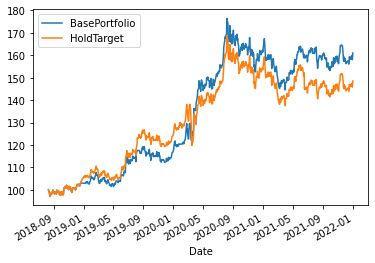

In [ ]:
#Backtest non metlabeled model
sharpe, max_drawdown, sortino = backtest(results, 5, metalabeled = False, signalCol = 'BaseSignal')
print('Sharpe: ', sharpe, 'max_drawdown', max_drawdown, 'sortino', sortino)
getInfo(results, 'Target', 'BaseSignal')
results = results.rename({'Portfolio': 'BasePortfolio'}, axis=1)
results.plot(y=['BasePortfolio', 'HoldTarget'])

count 134
total ret 0.6817711583992818
avg daily returns 0.0006427928418899942
ratio num 0.1407800003491925
rfr 0.035
sharpe:  1.0670945347278502 max_drawdown -0.15417617658237404 sortino 1.2115538090567228


<AxesSubplot:xlabel='Date'>

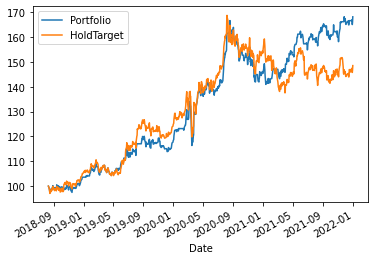

In [ ]:
#Backtest metalabeling model
sharpe, max_drawdown, sortino = backtestMeta(results, 5, metalabeled = True)
print('sharpe: ', sharpe, 'max_drawdown', max_drawdown, 'sortino', sortino)
results.plot(y=['Portfolio', 'HoldTarget'])

<AxesSubplot:xlabel='Date'>

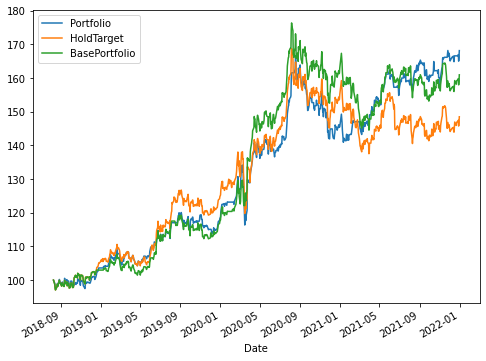

In [ ]:
#Plot Full Graph
results.plot(y=['Portfolio', 'HoldTarget', 'BasePortfolio'], figsize = (8, 6))

In [ ]:
# getInfo(results, 'Target', 'BaseSignal')


# stacking compare

In [ ]:
meta_results = results.copy()
meta_results.rename(columns = {'Portfolio' : 'Stacking'}, inplace = True)

,GLD,^VIX,^TNX,HG=F,SPY,FedRate,Target,MomentumGLD,MomentumSPY,MomentumHG=F,BaseSignal,BaseProbabilities,Metalabeled,BasePortfolio,SPYHold,HoldTarget,Daily Returns,Stacking
Date,,,,,,,,,,,,,,,,,,
2018-08-10 00:00:00-04:00,114.809998,12.340000,2.890,2.7465,262.460428,1.91,0,-0.009050,0.006364,-0.005558,1,0.572154,"[0.5, 0.5]",100.000000,100.000000,100.000000,0.000000,100.000000
2018-08-13 00:00:00-04:00,113.809998,14.500000,2.864,2.7130,262.478904,1.91,0,-0.016488,0.005671,-0.017180,1,0.571247,"[0.69, 0.31]",99.128996,100.007040,99.128996,-0.008710,99.128996
2018-08-14 00:00:00-04:00,113.250000,13.930000,2.893,2.6810,261.969663,1.91,0,-0.019761,0.003038,-0.027707,1,0.564976,"[0.4, 0.6]",98.641235,99.813014,98.641235,-0.004920,98.641235
2018-08-15 00:00:00-04:00,112.169998,13.520000,2.870,2.6700,261.469668,1.92,1,-0.027648,0.000335,-0.030307,1,0.567810,"[0.64, 0.36]",97.700549,99.622511,97.700549,-0.009536,97.700549
2018-08-16 00:00:00-04:00,111.459999,14.180000,2.873,2.5815,262.414108,1.92,1,-0.032184,0.003625,-0.061136,0,0.560636,"[0.79, 0.21]",97.082137,99.982352,97.082137,-0.006330,97.082137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27 00:00:00-05:00,168.960007,19.370001,1.489,4.3760,464.523902,0.08,0,0.012152,0.022033,0.014525,1,0.570516,"[0.46, 0.54]",159.509532,176.988168,147.164890,0.001441,156.465294
2021-12-28 00:00:00-05:00,169.330002,17.780001,1.486,4.4580,470.093516,0.08,0,0.014259,0.033019,0.034135,1,0.576122,"[0.65, 0.35]",159.858832,179.110245,147.487157,0.002190,156.807927
2021-12-29 00:00:00-05:00,167.360001,17.629999,1.505,4.4120,469.365373,0.08,1,0.001712,0.029718,0.021651,1,0.571247,"[0.63, 0.37]",157.999020,178.832816,145.771278,-0.011634,154.983609


In [ ]:
meta_results['Metalabeling'] = results['Portfolio']

In [ ]:
meta_results

<AxesSubplot:xlabel='Date'>

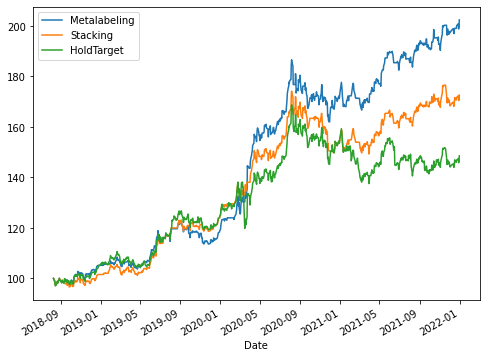

In [ ]:
meta_results.plot(y=['Metalabeling', 'Stacking', 'HoldTarget'], figsize = (8, 6))